# LINE: Large-scale Information Network Embedding

### Smapling method for Negative Samples 

In [15]:
import numpy as np

# This function creates an alias table from a given probability distribution. It's used for efficient sampling of negative samples
def create_alias_table(area_ratio):
    """

    :param area_ratio: sum(area_ratio)=1
    :return: accept,alias
    """
    l = len(area_ratio)
    accept, alias = [0] * l, [0] * l
    small, large = [], []
    area_ratio_ = np.array(area_ratio) * l
    for i, prob in enumerate(area_ratio_):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)

    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio_[small_idx]
        alias[small_idx] = large_idx
        area_ratio_[large_idx] = area_ratio_[large_idx] - \
                                 (1 - area_ratio_[small_idx])
        if area_ratio_[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)

    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1

    return accept, alias

# This function performs alias sampling
def alias_sample(accept, alias):
    """

    :param accept:
    :param alias:
    :return: sample index
    """
    N = len(accept)
    i = int(np.random.random() * N) # Selects an index i based on a uniform random variable
    r = np.random.random()
    # Returns the selected index if a secondary random check is below the accept threshold; otherwise, returns the alias index
    if r < accept[i]:
        return i
    else:
        return alias[i]

### Preprocess a graph

In [16]:
# Creates dictionaries to map nodes to indices (node2idx) and indices to nodes (idx2node)
def preprocess_nxgraph(graph):
    node2idx = {}
    idx2node = []
    node_size = 0
    for node in graph.nodes():
        node2idx[node] = node_size
        idx2node.append(node)
        node_size += 1
    return idx2node, node2idx

### Create model: set up embeddings and define the model used for training

In [17]:
import math
import random

'''
create_model(numNodes, embedding_size, order='second')
This function initializes the embeddings and defines the model.

Input:

numNodes: The number of nodes in the graph.
embedding_size: The size of the embedding vectors.
order: The order of proximity to be used ('first' or 'second').
Output:

model: A function that computes the dot product of embeddings for given node pairs.
embeddings: A dictionary containing the initialized embeddings.
'''
# sigmoid function, line_loss function, reduce_sum function for calculating the logistic loss between true value and predicted value
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def line_loss(y_true, y_pred):
    return -np.mean(np.log(sigmoid(y_true * y_pred)))


def reduce_sum(x, axis=None, keepdims=False):
    return np.sum(x, axis=axis, keepdims=keepdims)

# This function initializes the embeddings and defines the model. 
def create_model(numNodes, embedding_size, order='second'):
    # Randomly initializes embedding vectors for each node
    embeddings = {
        'first': np.random.rand(numNodes, embedding_size),
        'second': np.random.rand(numNodes, embedding_size),
        'context': np.random.rand(numNodes, embedding_size)
    }
    # Computes the dot product for first-order and second-order proximity between nodes
    def model(v_i, v_j):
        v_i_emb = embeddings['first'][v_i]
        v_j_emb = embeddings['first'][v_j]
        v_i_emb_second = embeddings['second'][v_i]
        v_j_context_emb = embeddings['context'][v_j]

        first_order = reduce_sum(v_i_emb * v_j_emb, axis=-1)
        second_order = reduce_sum(v_i_emb_second * v_j_context_emb, axis=-1)

        if order == 'first':
            return first_order
        elif order == 'second':
            return second_order
        else:
            return first_order, second_order

    return model, embeddings

### Create LINE

In [18]:
class LINE:
    # Sets up the LINE model with graph, embedding size, and other parameters
    # The constructor method where the model is initialized with the graph, embedding size, negative ratio, and order of proximity
    def __init__(self, graph, embedding_size=8, negative_ratio=5, order='second'):
        """
        :param graph:
        :param embedding_size:
        :param negative_ratio:
        :param order: 'first', 'second', 'all'
        """
        if order not in ['first', 'second', 'all']:
            raise ValueError('mode must be first, second, or all')

        self.graph = graph
        self.idx2node, self.node2idx = self.preprocess_nxgraph(graph)
        self.use_alias = True

        self.rep_size = embedding_size
        self.order = order

        self._embeddings = {}
        self.negative_ratio = negative_ratio
        self.order = order

        self.node_size = graph.number_of_nodes()
        self.edge_size = graph.number_of_edges()
        self.samples_per_epoch = self.edge_size * (1 + negative_ratio)

        self._gen_sampling_table()
        self.reset_model()

    # Preprocesses the graph to create node indices
    def preprocess_nxgraph(self, graph):
        idx2node = list(graph.nodes())
        node2idx = {node: idx for idx, node in enumerate(idx2node)}
        return idx2node, node2idx

    # Reset the training configuration with the given batch size and times
    def reset_training_config(self, batch_size, times):
        self.batch_size = batch_size
        self.steps_per_epoch = ((self.samples_per_epoch - 1) // self.batch_size + 1) * times

    # Resets the model and initializes the batch iterator
    def reset_model(self, opt='adam'):
        self.model, self.embeddings = create_model(self.node_size, self.rep_size, self.order)
        self.batch_it = self.batch_iter(self.node2idx)

    # Generates sampling tables for negative sampling
    def _gen_sampling_table(self):
        # create sampling table for vertex
        power = 0.75
        numNodes = self.node_size
        node_degree = np.zeros(numNodes)  # out degree
        node2idx = self.node2idx

        for edge in self.graph.edges():
            node_degree[node2idx[edge[0]]] += self.graph[edge[0]][edge[1]].get('weight', 1.0)

        total_sum = sum([math.pow(node_degree[i], power) for i in range(numNodes)])
        norm_prob = [float(math.pow(node_degree[j], power)) / total_sum for j in range(numNodes)]

        self.node_accept, self.node_alias = self.create_alias_table(norm_prob)

        # create sampling table for edge
        numEdges = self.graph.number_of_edges()
        total_sum = sum([self.graph[edge[0]][edge[1]].get('weight', 1.0) for edge in self.graph.edges()])
        norm_prob = [self.graph[edge[0]][edge[1]].get('weight', 1.0) * numEdges / total_sum for edge in self.graph.edges()]

        self.edge_accept, self.edge_alias = self.create_alias_table(norm_prob)

    # Construct an alias table for efficient negative sampling from a non-uniform distribution
    def create_alias_table(self, norm_prob):
        length = len(norm_prob)
        accept = np.zeros(length, dtype=np.float32)
        alias = np.zeros(length, dtype=np.int32)
        small = []
        large = []
        scaled_prob = np.array(norm_prob) * length
        for i, prob in enumerate(scaled_prob):
            if prob < 1.0:
                small.append(i)
            else:
                large.append(i)
        while small and large:
            small_idx = small.pop()
            large_idx = large.pop()
            accept[small_idx] = scaled_prob[small_idx]
            alias[small_idx] = large_idx
            scaled_prob[large_idx] = scaled_prob[large_idx] - (1.0 - scaled_prob[small_idx])
            if scaled_prob[large_idx] < 1.0:
                small.append(large_idx)
            else:
                large.append(large_idx)
        while large:
            large_idx = large.pop()
            accept[large_idx] = 1
        while small:
            small_idx = small.pop()
            accept[small_idx] = 1
        return accept, alias

    # Performs alias sampling
    def alias_sample(self, accept, alias):
        N = len(accept)
        i = int(np.random.rand() * N) 
        if np.random.rand() < accept[i]:
            return i
        else:
            return alias[i]
        
    # Generates batches of positive and negative samples for training
    def batch_iter(self, node2idx):
        edges = [(node2idx[x[0]], node2idx[x[1]]) for x in self.graph.edges()]
        data_size = self.graph.number_of_edges()
        shuffle_indices = np.random.permutation(np.arange(data_size))
        mod = 0
        mod_size = 1 + self.negative_ratio
        h = []
        t = []
        sign = 0
        count = 0
        start_index = 0
        end_index = min(start_index + self.batch_size, data_size)
        while True:
            if mod == 0:
                h = []
                t = []
                for i in range(start_index, end_index):
                    if random.random() >= self.edge_accept[shuffle_indices[i]]:
                        shuffle_indices[i] = self.edge_alias[shuffle_indices[i]]
                    cur_h = edges[shuffle_indices[i]][0]
                    cur_t = edges[shuffle_indices[i]][1]
                    h.append(cur_h)
                    t.append(cur_t)
                sign = np.ones(len(h))
            else:
                sign = np.ones(len(h)) * -1
                t = [self.alias_sample(self.node_accept, self.node_alias) for _ in range(len(h))]

            if self.order == 'all':
                yield ([np.array(h), np.array(t)], [sign, sign])
            else:
                yield ([np.array(h), np.array(t)], [sign])
            mod += 1
            mod %= mod_size
            if mod == 0:
                start_index = end_index
                end_index = min(start_index + self.batch_size, data_size)

            if start_index >= data_size:
                count += 1
                mod = 0
                h = []
                shuffle_indices = np.random.permutation(np.arange(data_size))
                start_index = 0
                end_index = min(start_index + self.batch_size, data_size)

    # Retrieve the learned embeddings for all nodes
    def get_embeddings(self):
        self._embeddings = {}
        if self.order == 'first':
            embeddings = self.embeddings['first']
        elif self.order == 'second':
            embeddings = self.embeddings['second']
        else:
            embeddings = np.hstack((self.embeddings['first'], self.embeddings['second']))
        idx2node = self.idx2node
        for i, embedding in enumerate(embeddings):
            self._embeddings[idx2node[i]] = embedding
        return self._embeddings

    # Runs through epochs and steps, generating batches and computing losses for first-order, second-order, or both proximities
    def train(self, batch_size=1024, epochs=1, initial_epoch=0, verbose=1, times=1):
        self.reset_training_config(batch_size, times)
        for epoch in range(initial_epoch, epochs):
            for step in range(self.steps_per_epoch):
                batch = next(self.batch_it)
                inputs, targets = batch
                v_i, v_j = inputs
                if self.order == 'all':
                    sign_first, sign_second = targets
                    first_order, second_order = self.model(v_i, v_j)
                    loss_first = line_loss(sign_first, first_order)
                    loss_second = line_loss(sign_second, second_order)
                    loss = loss_first + loss_second
                else:
                    sign = targets
                    preds = self.model(v_i, v_j)
                    loss = line_loss(sign, preds)
                if verbose:
                    print(f'Epoch {epoch + 1}/{epochs}, Step {step + 1}/{self.steps_per_epoch}, Loss: {loss}')
        return

### Train and visualize LINE embeddings

Epoch 1/50, Step 1/1, Loss: 1.7355347928035464e-13
Epoch 2/50, Step 1/1, Loss: 31.624076823349807
Epoch 3/50, Step 1/1, Loss: 31.169309395731215
Epoch 4/50, Step 1/1, Loss: 31.12885367433243
Epoch 5/50, Step 1/1, Loss: 31.2851341590613
Epoch 6/50, Step 1/1, Loss: 31.850230021772397
Epoch 7/50, Step 1/1, Loss: 1.7355347928035464e-13
Epoch 8/50, Step 1/1, Loss: 31.105735518626098
Epoch 9/50, Step 1/1, Loss: 31.557213269222213
Epoch 10/50, Step 1/1, Loss: 31.114713289703193
Epoch 11/50, Step 1/1, Loss: 31.54052802374784
Epoch 12/50, Step 1/1, Loss: 31.153761287134575
Epoch 13/50, Step 1/1, Loss: 1.7355347928035464e-13
Epoch 14/50, Step 1/1, Loss: 31.483634637710765
Epoch 15/50, Step 1/1, Loss: 31.354196302792815
Epoch 16/50, Step 1/1, Loss: 31.722616097164618
Epoch 17/50, Step 1/1, Loss: 31.359406848522724
Epoch 18/50, Step 1/1, Loss: 30.888375801946832
Epoch 19/50, Step 1/1, Loss: 1.7355347928035464e-13
Epoch 20/50, Step 1/1, Loss: 31.248925651889824
Epoch 21/50, Step 1/1, Loss: 31.67919

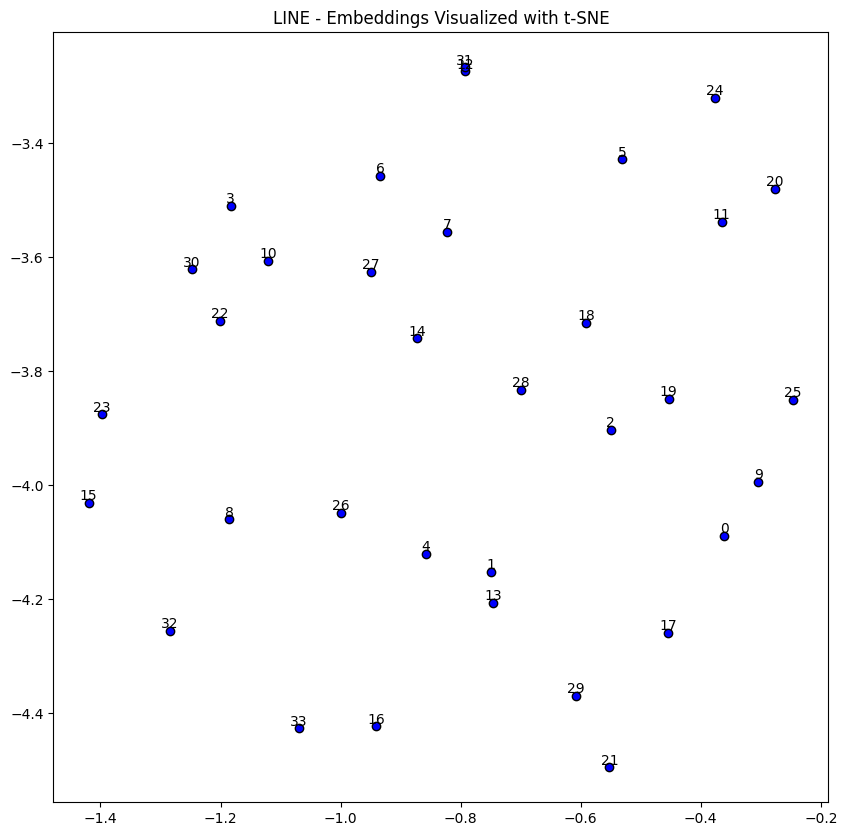

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load the graph
G = nx.karate_club_graph()

# Initialize the model
model = LINE(G, embedding_size=128, order='second')  # order can be ['first', 'second', 'all']
model.train(batch_size=1024, epochs=50, verbose=2)  # Train the model

# Get the embedding vectors
embeddings = model.get_embeddings()

# Convert embeddings to a numpy array for easier handling
nodes = list(embeddings.keys())
emb_array = np.array([embeddings[node] for node in nodes])

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(emb_array)

# Plot the 2D embeddings
plt.figure(figsize=(10, 10))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c='blue', edgecolors='k')

# Optionally, label the points with node identifiers
for i, node in enumerate(nodes):
    plt.annotate(node, (emb_2d[i, 0], emb_2d[i, 1]), textcoords='offset points', xytext=(0, 2), ha='center')

plt.title('LINE - Embeddings Visualized with t-SNE')
plt.show()


# Asymmetric Transitivity Preserving Graph Embedding (HOPE)

### Create HOPE

In [20]:
import networkx as nx
import numpy as np
import scipy.sparse.linalg as lg

class HOPE(object):
    def __init__(self, graph, d):
        '''
          d: representation vector dimension
        '''
        self._d = d # The dimension of the representation vector (embedding)
        self._graph = graph.G # Stores the NetworkX graph from the Graph object
        self.g = graph # Stores the Graph object
        self._node_num = graph.node_size # Stores the number of nodes in the graph
        self.learn_embedding() # Learn the embeddings when initializing the object

    def learn_embedding(self):

        graph = self.g.G
        A = nx.to_numpy_array(graph) # Get the adjacency matrix of the graph

        M_g = np.eye(graph.number_of_nodes()) # Create an identity matrix
        M_l = np.dot(A, A) # Compute the squared adjacency matrix

        S = np.dot(np.linalg.inv(M_g), M_l) #  Computes the similarity matrix
        # s: \sigma_k
        u, s, vt = lg.svds(S, k=self._d // 2) # Perform SVD on S, getting the top k singular values/vectors (with k = self._d // 2)
        sigma = np.diagflat(np.sqrt(s)) # Creates a diagonal matrix from the square roots of the singular values
        X1 = np.dot(u, sigma) #Compute the embeddings
        X2 = np.dot(vt.T, sigma) # Compute the embeddings

        self._X = np.concatenate((X1, X2), axis=1) # Placeholder for the final embeddings

    @property
    def vectors(self):
        vectors = {}
        look_back = self.g.look_back_list # list of nodes
        # For each node, the corresponding embedding is added to the vectors dictionary
        for i, embedding in enumerate(self._X):
            vectors[look_back[i]] = embedding
        return vectors

    # Save embeddings to a file
    def save_embeddings(self, filename):
        fout = open(filename, 'w')
        node_num = len(self.vectors.keys())
        fout.write("{} {}\n".format(node_num, self._d))
        for node, vec in self.vectors.items():
            fout.write("{} {}\n".format(node,
                                        ' '.join([str(x) for x in vec])))
        fout.close()

class Graph:
    def __init__(self, nx_G):
        self.G = nx_G # Store graph object 
        self.node_size = self.G.number_of_nodes() #Store the number of nodes in the graph
        self.look_back_list = list(self.G.nodes()) # Store list of nodes in the graph

### Train and visualize HOPE

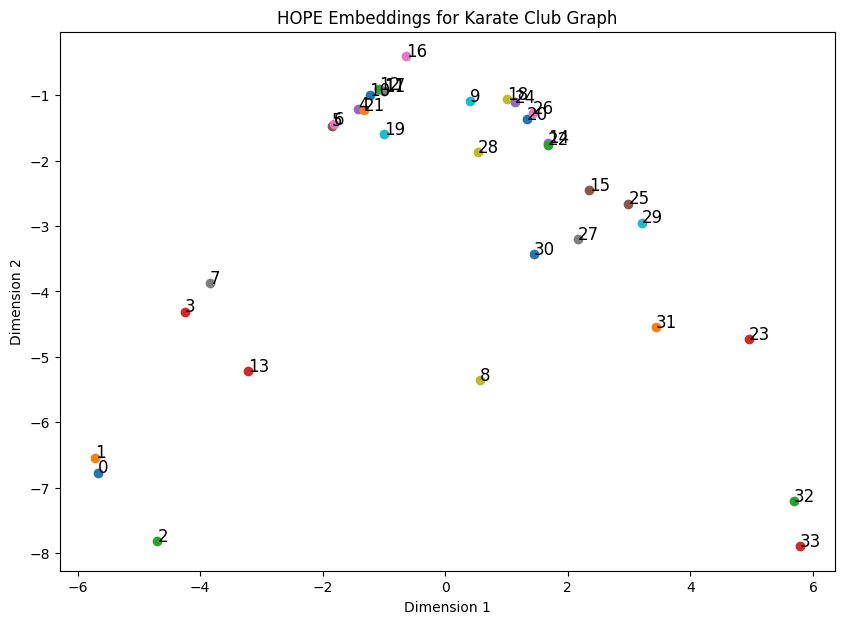

In [21]:
# Create the Karate Club graph
G = nx.karate_club_graph()
graph = Graph(G)

# Initialize HOPE with the graph and desired embedding dimension
hope = HOPE(graph, d=4)

# Get the embeddings
embeddings = hope.vectors

# Visualize the embeddings
def plot_embeddings(embeddings):
    plt.figure(figsize=(10, 7))
    for node, emb in embeddings.items():
        plt.scatter(emb[0], emb[1], marker='o')
        plt.text(emb[0], emb[1], s=str(node), fontsize=12)
    plt.title("HOPE Embeddings for Karate Club Graph")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Plot the embeddings
plot_embeddings(embeddings)

# Scalable Graph Embedding for Asymmetric Proximity (APP)


### Create APP

Model Setting:
	dimension:		16
Model:
	[APP]
Learning Parameters:
	walk_times:		10
	sample_times:		5
	jumping factor:		0.2
	negative_samples:	5
	alpha:			0.025
	workers:		4
Start Training:
	Alpha: 0.000074	Progress: 100.00 %
Save Model:
	Save to <embeddings.txt>


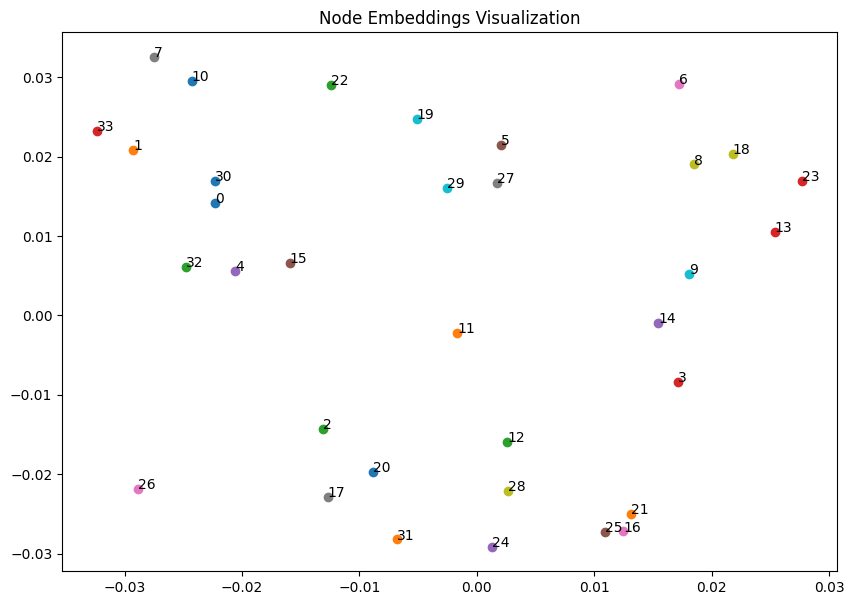

In [22]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

class APP:
    
    def __init__(self):
        self.dim = 0 # Dimension of the embeddings
        self.w_vertex = None # Vertex embeddings
        self.w_context = None # Context embeddings
        self.pnet = None # stores the graph structure
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    #Loads the graph into the pnet attribute. It optionally converts the graph to an undirected graph
    def load_edge_list(self, graph, undirect=True):
        self.pnet = graph
        if undirect:
            self.pnet = self.pnet.to_undirected()
    
    # Save weights to a file for analysis
    def save_weights(self, model_name):
        print("Save Model:")
        with open(model_name, 'w') as model:
            model.write(f"{self.pnet.number_of_nodes()} {self.dim}\n")
            for node in self.pnet.nodes():
                model.write(f"{node}")
                for d in range(self.dim):
                    model.write(f" {self.w_vertex[node][d]}")
                model.write("\n")
        print(f"\tSave to <{model_name}>")

    # Initialization: set the embedding dimensionality and initializes the embeddings for vertices and contexts randomly.
    def init(self, dim):
        self.dim = dim
        print("Model Setting:")
        print(f"\tdimension:\t\t{dim}")
        
        self.w_vertex = {node: (np.random.rand(dim) - 0.5) / dim for node in self.pnet.nodes()}
        self.w_context = {node: (np.random.rand(dim) - 0.5) / dim for node in self.pnet.nodes()}
    
    def train(self, walk_times, sample_times, jump, negative_samples, alpha, workers):
        total = walk_times * self.pnet.number_of_nodes()
        alpha_min = alpha * 0.0001
        _alpha = alpha
        count = 0
        
        print("Model:")
        print("\t[APP]")
        
        print("Learning Parameters:")
        print(f"\twalk_times:\t\t{walk_times}") # Number of random walks to perform per node
        print(f"\tsample_times:\t\t{sample_times}") # Number of times to sample context nodes per random walk
        print(f"\tjumping factor:\t\t{jump}") # Probability of jumping to a random node during a random walk
        print(f"\tnegative_samples:\t{negative_samples}") # Number of negative samples to use per positive sample
        print(f"\talpha:\t\t\t{alpha}") # Learning rate
        print(f"\tworkers:\t\t{workers}") # Number of workers
        
        print("Start Training:")
        
        for t in range(walk_times):
            random_keys = list(self.pnet.nodes())
            random.shuffle(random_keys)
            
            for vid in random_keys:
                for s in range(sample_times):
                    walks = self.random_walk(vid, jump)
                    self.update_pair(walks[0], walks[-1], _alpha, negative_samples)
                
                count += 1
                if count % (total // 100) == 0:
                    _alpha = alpha * (1.0 - count / total)
                    if _alpha < alpha_min:
                        _alpha = alpha_min
                    print(f"\tAlpha: {_alpha:.6f}\tProgress: {count / total * 100:.2f}%", end='\r')
        
        print(f"\tAlpha: {_alpha:.6f}\tProgress: 100.00 %")
    
    # Generates a random walk in the graph starting from a given node
    def random_walk(self, start, jump):
        walk = [start]
        while True:
            current = walk[-1]
            neighbors = list(self.pnet.neighbors(current))
            if not neighbors or random.random() < jump:
                break
            walk.append(random.choice(neighbors))
        return walk
    
    # Update the embeddings based on the positive and negative samples
    def update_pair(self, v1, v2, alpha, negative_samples):
        v1_embedding = self.w_vertex[v1]
        v2_embedding = self.w_context[v2]

        # Positive sample update
        score = np.dot(v1_embedding, v2_embedding)
        gradient = alpha * (1 - self.sigmoid(score))
        self.w_vertex[v1] += gradient * v2_embedding
        self.w_context[v2] += gradient * v1_embedding
        
        # Negative samples update
        for _ in range(negative_samples):
            negative_v = random.choice(list(self.pnet.nodes()))
            if negative_v == v2:
                continue
            
            negative_v_embedding = self.w_context[negative_v]
            score = np.dot(v1_embedding, negative_v_embedding)
            gradient = alpha * (-self.sigmoid(score))
            self.w_vertex[v1] += gradient * negative_v_embedding
            self.w_context[negative_v] += gradient * v1_embedding

# Load the karate club graph
G = nx.karate_club_graph()

# Create APP instance and load the graph
app = APP()
app.load_edge_list(G)

# Initialize the embeddings with a specified dimension
app.init(dim=16)

# Train the model (parameters are examples)
app.train(walk_times=10, sample_times=5, jump=0.2, negative_samples=5, alpha=0.025, workers=4)

# Save the trained weights to a file
app.save_weights("embeddings.txt")

# Extract and visualize the embeddings
embeddings = np.array([app.w_vertex[node] for node in G.nodes()])
plt.figure(figsize=(10, 7))
for i, node in enumerate(G.nodes()):
    plt.scatter(embeddings[i, 0], embeddings[i, 1])
    plt.annotate(node, (embeddings[i, 0], embeddings[i, 1]))
plt.title("Node Embeddings Visualization")
plt.show()


# Struc2Vec: Learning Node Representations from Structural Identity

### Define functions

In [36]:
"""
Divide a dictionary of vertices into chunks for parallel processing

It takes the vertices dictionary and the number of workers as input

Then, it iterates through the vertices, creating chunks of vertices based on the batch size

Finally, it returns a list of partitions containing these chunks
"""
def partition_dict(vertices, workers):
    batch_size = (len(vertices) - 1) // workers + 1
    part_list = []
    part = []
    count = 0
    for v1, nbs in vertices.items():
        part.append((v1, nbs))
        count += 1
        if count % batch_size == 0:
            part_list.append(part)
            part = []
    if len(part) > 0:
        part_list.append(part)
    return part_list

# Distribute a number into almost equal parts for workers
def partition_num(num, workers):
    if num % workers == 0:
        return [num // workers] * workers
    else:
        return [num // workers] * workers + [num % workers]

### Create BiasedWalker: simulating biased random walks on the graph

In [37]:
from joblib import Parallel, delayed

# Generates biased random walks on a graph. It initializes with the index-to-node mapping and a temporary path for storing intermediate results
class BiasedWalker:
    def __init__(self, idx2node, temp_path):

        self.idx2node = idx2node
        self.idx = list(range(len(self.idx2node)))
        self.temp_path = temp_path
        pass

    # Generates random walks on the graph. It takes parameters such as the number of walks, walk length.
    def simulate_walks(self, num_walks, walk_length, stay_prob=0.3, workers=1, verbose=0):

        layers_adj = pd.read_pickle(self.temp_path + 'layers_adj.pkl')
        layers_alias = pd.read_pickle(self.temp_path + 'layers_alias.pkl')
        layers_accept = pd.read_pickle(self.temp_path + 'layers_accept.pkl')
        gamma = pd.read_pickle(self.temp_path + 'gamma.pkl')

        nodes = self.idx  # list(self.g.nodes())

        # Parallelizes the generation of random walks
        results = Parallel(n_jobs=workers, verbose=verbose, )(
            delayed(self._simulate_walks)(nodes, num, walk_length, stay_prob, layers_adj, layers_accept, layers_alias,
                                          gamma) for num in
            partition_num(num_walks, workers))
        # Each worker generates walks for a portion of the walks, and the results are combined
        walks = list(itertools.chain(*results))
        return walks

    # Perform the actual random walk generation. It shuffles the nodes and iterates over them to simulate walks
    def _simulate_walks(self, nodes, num_walks, walk_length, stay_prob, layers_adj, layers_accept, layers_alias, gamma):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                walks.append(self._exec_random_walk(layers_adj, layers_accept, layers_alias,
                                                    v, walk_length, gamma, stay_prob))
        return walks

    # Execute a single random walk. It handles both staying in the same layer and moving to a different layer based on probabilities
    def _exec_random_walk(self, graphs, layers_accept, layers_alias, v, walk_length, gamma, stay_prob=0.3):
        initialLayer = 0
        layer = initialLayer

        path = []
        path.append(self.idx2node[v])

        while len(path) < walk_length:
            r = random.random()
            if (r < stay_prob):  # same layer
                v = chooseNeighbor(v, graphs, layers_alias,
                                   layers_accept, layer)
                path.append(self.idx2node[v])
            else:  # different layer
                r = random.random()
                try:
                    x = math.log(gamma[layer][v] + math.e)
                    p_moveup = (x / (x + 1))
                except:
                    print(layer, v)
                    raise ValueError()

                if (r > p_moveup):
                    if (layer > initialLayer):
                        layer = layer - 1
                else:
                    if ((layer + 1) in graphs and v in graphs[layer + 1]):
                        layer = layer + 1

        return path


def chooseNeighbor(v, graphs, layers_alias, layers_accept, layer):
    v_list = graphs[layer][v]

    idx = alias_sample(layers_accept[layer][v], layers_alias[layer][v])
    v = v_list[idx]

    return v

### Create Struc2Vec

In [75]:
import math
import os
import shutil
from collections import ChainMap, deque
import random

import numpy as np
import pandas as pd
from fastdtw import fastdtw
from joblib import Parallel, delayed


class Struc2Vec():
    """
    The constructor initializes various parameters and sets up the environment for running the Struc2Vec algorithm. 
    It takes several parameters such as the input graph, walk length, number of walks, etc. The key steps in the constructor include:

    1/ Preprocessing the input graph to create node index mappings.
    2/ Creating a temporary directory for storing intermediate results if it doesn't exist.
    3/ Initializing parameters and calling methods to create the context graph, prepare biased random walks, and simulate walks on the graph.
    """
    def __init__(self, graph, walk_length=10, num_walks=100, workers=1, verbose=0, stay_prob=0.3, opt1_reduce_len=True,
                 opt2_reduce_sim_calc=True, opt3_num_layers=None, temp_path='./temp_struc2vec/', reuse=False):
        self.graph = graph
        self.idx2node, self.node2idx = preprocess_nxgraph(graph)
        self.idx = list(range(len(self.idx2node)))

        self.opt1_reduce_len = opt1_reduce_len
        self.opt2_reduce_sim_calc = opt2_reduce_sim_calc
        self.opt3_num_layers = opt3_num_layers

        self.reuse = reuse
        self.temp_path = temp_path

        if not os.path.exists(self.temp_path):
            os.mkdir(self.temp_path)
        if not reuse:
            shutil.rmtree(self.temp_path)
            os.mkdir(self.temp_path)

        self.create_context_graph(self.opt3_num_layers, workers, verbose)
        self.prepare_biased_walk()
        self.walker = BiasedWalker(self.idx2node, self.temp_path)
        self.sentences = self.walker.simulate_walks(
            num_walks, walk_length, stay_prob, workers, verbose)

        self._embeddings = {}

    # Create a context graph based on the input graph 
    # It computes pair-wise structural distances between nodes in the graph and generates transition probabilities for nodes in each layer of the context graph
    def create_context_graph(self, max_num_layers, workers=1, verbose=0):
        pair_distances = self._compute_structural_distance(max_num_layers, workers, verbose)
        layers_adj, layers_distances = self._get_layer_rep(pair_distances)
        pd.to_pickle(layers_adj, self.temp_path + 'layers_adj.pkl')

        layers_accept, layers_alias = self._get_transition_probs(layers_adj, layers_distances)
        pd.to_pickle(layers_alias, self.temp_path + 'layers_alias.pkl')
        pd.to_pickle(layers_accept, self.temp_path + 'layers_accept.pkl')

    # Prepares for biased random walks by computing various statistics such as sum of weights, average weight, and gamma for each layer of the context graph
    def prepare_biased_walk(self):
        sum_weights = {}
        sum_edges = {}
        average_weight = {}
        gamma = {}
        layer = 0
        while os.path.exists(self.temp_path + 'norm_weights_distance-layer-' + str(layer) + '.pkl'):
            probs = pd.read_pickle(self.temp_path + 'norm_weights_distance-layer-' + str(layer) + '.pkl')
            for v, list_weights in probs.items():
                sum_weights.setdefault(layer, 0)
                sum_edges.setdefault(layer, 0)
                sum_weights[layer] += sum(list_weights)
                sum_edges[layer] += len(list_weights)

            average_weight[layer] = sum_weights[layer] / sum_edges[layer]
            gamma[layer] = {}

            for v, list_weights in probs.items():
                num_neighbours = 0
                for w in list_weights:
                    if w > average_weight[layer]:
                        num_neighbours += 1
                gamma[layer][v] = num_neighbours

            layer += 1

        pd.to_pickle(average_weight, self.temp_path + 'average_weight.pkl')
        pd.to_pickle(gamma, self.temp_path + 'gamma.pkl')

    # Train a Skip-gram model using the generated random walks as training data. It initializes weights, performs forward pass, computes loss using cross-entropy loss, and updates weights using backpropagation
    def train_skipgram(self, embed_size=128, window_size=5, learning_rate=0.01, epochs=5):
        # Prepare training data
        data = self.generate_training_data(window_size)
        vocab_size = len(self.idx2node)

        # Initialize weights
        W1 = np.random.rand(vocab_size, embed_size)
        W2 = np.random.rand(embed_size, vocab_size)

        for epoch in range(epochs):
            loss = 0
            for target, context in data:
                target_one_hot = self.one_hot(target, vocab_size)
                context_one_hot = self.one_hot(context, vocab_size)

                # Forward pass
                hidden_layer = np.dot(W1.T, target_one_hot)
                output_layer = np.dot(W2.T, hidden_layer)
                predicted_context = self.softmax(output_layer)

                # Compute loss (cross-entropy loss)
                loss += -np.sum(context_one_hot * np.log(predicted_context + 1e-9))

                # Backpropagation
                error = predicted_context - context_one_hot
                dW2 = np.outer(hidden_layer, error)
                dW1 = np.outer(target_one_hot, np.dot(W2, error))

                # Update weights
                W1 -= learning_rate * dW1
                W2 -= learning_rate * dW2

            print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

        self.W1 = W1
        self.W2 = W2
        return W1, W2

    # Generate training data for Skip-gram model by creating pairs of target and context nodes from the simulated random walks
    def generate_training_data(self, window_size):
        pairs = []
        for sentence in self.sentences:
            for i, target in enumerate(sentence):
                context_indices = list(range(max(0, i - window_size), i)) + \
                                  list(range(i + 1, min(len(sentence), i + window_size + 1)))
                for context in context_indices:
                    pairs.append((self.node2idx[target], self.node2idx[sentence[context]]))
        return pairs

    def one_hot(self, idx, vocab_size):
        one_hot_vec = np.zeros(vocab_size)
        one_hot_vec[idx] = 1
        return one_hot_vec

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    # Retrieve node embeddings learned by the Skip-gram model
    def get_embeddings(self):
        if not hasattr(self, 'W1'):
            print("Model not trained")
            return {}

        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.W1[self.node2idx[word]]

        return self._embeddings

    # Computes an ordered degree list for each node in the graph. 
    # It iterates over all vertices in the graph, and for each vertex, it calls the _get_order_degreelist_node method to compute the ordered degree list
    # The ordered degree list represents the degrees of neighboring nodes in each layer of the graph
    def _compute_ordered_degreelist(self, max_num_layers):
        degreeList = {}
        vertices = self.idx
        for v in vertices:
            degreeList[v] = self._get_order_degreelist_node(v, max_num_layers)
        return degreeList

    # Compute the ordered degree list for a given node. 
    # It performs a breadth-first search (BFS) traversal starting from the given node and collects the degrees of neighboring nodes at each level of the traversal
    # The collected degrees are stored in a dictionary where the keys represent the level (or layer) of the traversal
    def _get_order_degreelist_node(self, root, max_num_layers=None):
        if max_num_layers is None:
            max_num_layers = float('inf')

        ordered_degree_sequence_dict = {}
        visited = [False] * len(self.graph.nodes())
        queue = deque()
        level = 0
        queue.append(root)
        visited[root] = True

        while len(queue) > 0 and level <= max_num_layers:
            count = len(queue)
            if self.opt1_reduce_len:
                degree_list = {}
            else:
                degree_list = []
            while count > 0:
                top = queue.popleft()
                node = self.idx2node[top]
                degree = len(self.graph[node])

                if self.opt1_reduce_len:
                    degree_list[degree] = degree_list.get(degree, 0) + 1
                else:
                    degree_list.append(degree)

                for nei in self.graph[node]:
                    nei_idx = self.node2idx[nei]
                    if not visited[nei_idx]:
                        visited[nei_idx] = True
                        queue.append(nei_idx)
                count -= 1

            if self.opt1_reduce_len:
                orderd_degree_list = [(degree, freq) for degree, freq in degree_list.items()]
                orderd_degree_list.sort(key=lambda x: x[0])
            else:
                orderd_degree_list = sorted(degree_list)
            ordered_degree_sequence_dict[level] = orderd_degree_list
            level += 1

        return ordered_degree_sequence_dict

    # Compute structural distances between pairs of nodes in the graph
    # It first checks if the precomputed structural distances exist in the temporary directory
    # If not, it computes the structural distances using dynamic time warping (DTW) algorithm
    # The DTW algorithm computes the similarity between ordered degree lists of nodes
    def _compute_structural_distance(self, max_num_layers, workers=1, verbose=0):
        if os.path.exists(self.temp_path + 'structural_dist.pkl'):
            structural_dist = pd.read_pickle(self.temp_path + 'structural_dist.pkl')
        else:
            if self.opt1_reduce_len:
                dist_func = cost_max
            else:
                dist_func = cost

            if os.path.exists(self.temp_path + 'degreelist.pkl'):
                degreeList = pd.read_pickle(self.temp_path + 'degreelist.pkl')
            else:
                degreeList = self._compute_ordered_degreelist(max_num_layers)
                pd.to_pickle(degreeList, self.temp_path + 'degreelist.pkl')

            if self.opt2_reduce_sim_calc:
                degrees = self._create_vectors()
                degreeListsSelected = {}
                vertices = {}
                n_nodes = len(self.idx)
                for v in self.idx:
                    nbs = get_vertices(v, len(self.graph[self.idx2node[v]]), degrees, n_nodes)
                    vertices[v] = nbs
                    degreeListsSelected[v] = degreeList[v]
                    for n in nbs:
                        degreeListsSelected[n] = degreeList[n]
            else:
                vertices = {v: [vd for vd in degreeList.keys() if vd > v] for v in degreeList}

            results = Parallel(n_jobs=workers, verbose=verbose)(
                delayed(compute_dtw_dist)(part_list, degreeList, dist_func) for part_list in
                partition_dict(vertices, workers))
            dtw_dist = dict(ChainMap(*results))

            structural_dist = convert_dtw_struc_dist(dtw_dist)
            pd.to_pickle(structural_dist, self.temp_path + 'structural_dist.pkl')

        return structural_dist

    # Create a dictionary of degrees for each node in the graph
    # It iterates over all nodes in the graph, computes the degree of each node, and stores the node indices in lists based on their degrees
    # It sorts the unique degrees in ascending order and stores them for later use
    def _create_vectors(self):
        degrees = {}
        degrees_sorted = set()
        G = self.graph
        for v in self.idx:
            degree = len(G[self.idx2node[v]])
            degrees_sorted.add(degree)
            if degree not in degrees:
                degrees[degree] = {'vertices': []}
            degrees[degree]['vertices'].append(v)
        degrees_sorted = np.array(list(degrees_sorted), dtype='int')
        degrees_sorted = np.sort(degrees_sorted)

        l = len(degrees_sorted)
        for index, degree in enumerate(degrees_sorted):
            if index > 0:
                degrees[degree]['before'] = degrees_sorted[index - 1]
            if index < (l - 1):
                degrees[degree]['after'] = degrees_sorted[index + 1]

        return degrees

    # Construct the layer representation of the context graph
    # It takes pair-wise distances between nodes and organizes them into layers based on the distance
    # It constructs the adjacency matrix for each layer
    def _get_layer_rep(self, pair_distances):
        layer_distances = {}
        layer_adj = {}
        for v_pair, layer_dist in pair_distances.items():
            for layer, distance in layer_dist.items():
                vx = v_pair[0]
                vy = v_pair[1]

                layer_distances.setdefault(layer, {})
                layer_distances[layer][vx, vy] = distance

                layer_adj.setdefault(layer, {})
                layer_adj[layer].setdefault(vx, [])
                layer_adj[layer].setdefault(vy, [])
                layer_adj[layer][vx].append(vy)
                layer_adj[layer][vy].append(vx)

        return layer_adj, layer_distances

    # Compute transition probabilities for nodes in each layer of the context graph
    # It calculates the weights between neighboring nodes and computes normalized transition probabilities using exponential decay 
    # It creates alias tables for efficient sampling during biased random walks
    def _get_transition_probs(self, layers_adj, layers_distances):
        layers_alias = {}
        layers_accept = {}

        for layer in layers_adj:
            neighbors = layers_adj[layer]
            layer_distances = layers_distances[layer]
            node_alias_dict = {}
            node_accept_dict = {}
            norm_weights = {}

            for v, neighbors in neighbors.items():
                e_list = []
                sum_w = 0.0

                for n in neighbors:
                    if (v, n) in layer_distances:
                        wd = layer_distances[v, n]
                    else:
                        wd = layer_distances[n, v]
                    w = np.exp(-float(wd))
                    e_list.append(w)
                    sum_w += w

                e_list = [x / sum_w for x in e_list]
                norm_weights[v] = e_list
                accept, alias = create_alias_table(e_list)
                node_alias_dict[v] = alias
                node_accept_dict[v] = accept

            pd.to_pickle(norm_weights, self.temp_path + 'norm_weights_distance-layer-' + str(layer) + '.pkl')

            layers_alias[layer] = node_alias_dict
            layers_accept[layer] = node_accept_dict

        return layers_accept, layers_alias

# Calculate the cost between two values a and b
# It uses a normalization formula to compute the cost based on the maximum and minimum values between a and b
def cost(a, b):
    ep = 0.5
    m = max(a, b) + ep
    mi = min(a, b) + ep
    return ((m / mi) - 1)

# Similar to the cost function, this function computes the cost between two tuples a and b, where each tuple consists of a value and a multiplicative weight
# It calculates the cost based on the minimum weight between the two tuples
def cost_min(a, b):
    ep = 0.5
    m = max(a[0], b[0]) + ep
    mi = min(a[0], b[0]) + ep
    return ((m / mi) - 1) * min(a[1], b[1])

# Similar to cost_min but computes the cost based on the maximum weight between the two tuples
def cost_max(a, b):
    ep = 0.5
    m = max(a[0], b[0]) + ep
    mi = min(a[0], b[0]) + ep
    return ((m / mi) - 1) * max(a[1], b[1])

# Convert the dynamic time warping (DTW) structural distances computed between pairs of nodes into cumulative distances across layers
# It iterates over the distances dictionary, adds the distances of each layer to the previous layer, and returns the modified distances dictionary
def convert_dtw_struc_dist(distances, startLayer=1):
    for vertices, layers in distances.items():
        keys_layers = sorted(layers.keys())
        startLayer = min(len(keys_layers), startLayer)
        for layer in range(0, startLayer):
            keys_layers.pop(0)

        for layer in keys_layers:
            layers[layer] += layers[layer - 1]
    return distances

# Select neighboring vertices of a given node v based on their degrees
# It iterates over the vertices with the same degree as v and then iteratively selects vertices with degrees closer to v until a certain number of vertices are selected or no more vertices are available
def get_vertices(v, degree_v, degrees, n_nodes):
    a_vertices_selected = 2 * math.log(n_nodes, 2)
    vertices = []
    try:
        c_v = 0

        for v2 in degrees[degree_v]['vertices']:
            if (v != v2):
                vertices.append(v2)  # same degree
                c_v += 1
                if (c_v > a_vertices_selected):
                    raise StopIteration

        if ('before' not in degrees[degree_v]):
            degree_b = -1
        else:
            degree_b = degrees[degree_v]['before']
        if ('after' not in degrees[degree_v]):
            degree_a = -1
        else:
            degree_a = degrees[degree_v]['after']
        if (degree_b == -1 and degree_a == -1):
            raise StopIteration  # not anymore v
        degree_now = verifyDegrees(degrees, degree_v, degree_a, degree_b)
        # nearest valid degree
        while True:
            for v2 in degrees[degree_now]['vertices']:
                if (v != v2):
                    vertices.append(v2)
                    c_v += 1
                    if (c_v > a_vertices_selected):
                        raise StopIteration

            if (degree_now == degree_b):
                if ('before' not in degrees[degree_b]):
                    degree_b = -1
                else:
                    degree_b = degrees[degree_b]['before']
            else:
                if ('after' not in degrees[degree_a]):
                    degree_a = -1
                else:
                    degree_a = degrees[degree_a]['after']

            if (degree_b == -1 and degree_a == -1):
                raise StopIteration

            degree_now = verifyDegrees(degrees, degree_v, degree_a, degree_b)

    except StopIteration:
        return list(vertices)

    return list(vertices)

# Determine the next valid degree based on the current degree and its neighboring degrees
# It selects the degree closest to the root degree degree_v_root among the neighboring degrees degree_a and degree_b
def verifyDegrees(degrees, degree_v_root, degree_a, degree_b):
    if (degree_b == -1):
        degree_now = degree_a
    elif (degree_a == -1):
        degree_now = degree_b
    elif (abs(degree_b - degree_v_root) < abs(degree_a - degree_v_root)):
        degree_now = degree_b
    else:
        degree_now = degree_a

    return degree_now

# Compute the dynamic time warping (DTW) distances between pairs of nodes in a partitioned list (part_list)
# It iterates over each pair of nodes, retrieves their ordered degree lists from degreeList, and computes the DTW distance using the specified distance function dist_func
def compute_dtw_dist(part_list, degreeList, dist_func):
    dtw_dist = {}
    for v1, nbs in part_list:
        lists_v1 = degreeList[v1]  # lists_v1 :orderd degree list of v1
        for v2 in nbs:
            lists_v2 = degreeList[v2]  # lists_v1 :orderd degree list of v2
            max_layer = min(len(lists_v1), len(lists_v2))  # valid layer
            dtw_dist[v1, v2] = {}
            for layer in range(0, max_layer):
                dist, path = fastdtw(
                    lists_v1[layer], lists_v2[layer], radius=1, dist=dist_func)
                dtw_dist[v1, v2][layer] = dist
    return dtw_dist

### Train and visualize Struc2vec

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


Epoch 1, Loss: 530937.1229
Epoch 2, Loss: 528733.1326
Epoch 3, Loss: 532038.3388
Epoch 4, Loss: 534786.9516
Epoch 5, Loss: 536657.5063


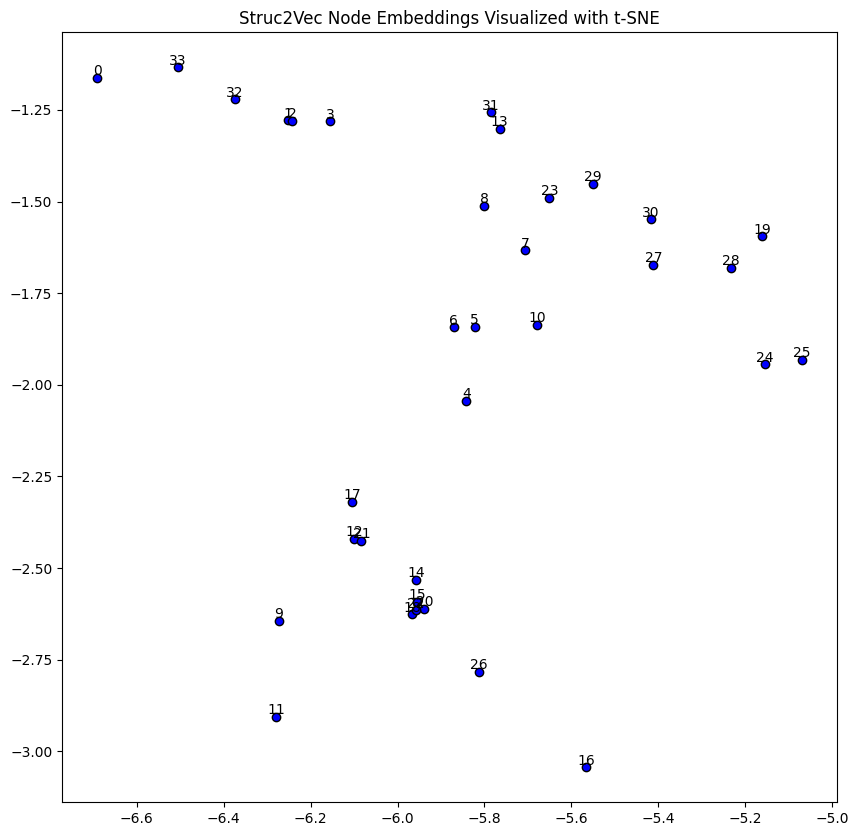

In [79]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import itertools

# Load the Karate Club graph
G = nx.karate_club_graph()

# Initialize the Struc2Vec model
model = Struc2Vec(G, walk_length=10, num_walks=100, workers=4, verbose=1)

# Train the model to get the embeddings
model.train_skipgram(embed_size=128, window_size=5)

# Get the embedding vectors
embeddings = model.get_embeddings()

# Convert embeddings to a numpy array for easier handling
nodes = list(embeddings.keys())
emb_array = np.array([embeddings[node] for node in nodes])

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(emb_array)

# Plot the 2D embeddings
plt.figure(figsize=(10, 10))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c='blue', edgecolors='k')

# Optionally, label the points with node identifiers
for i, node in enumerate(nodes):
    plt.annotate(node, (emb_2d[i, 0], emb_2d[i, 1]), textcoords='offset points', xytext=(0, 2), ha='center')

plt.title('Struc2Vec Node Embeddings Visualized with t-SNE')
plt.show()


# Learning Role-Based Graph Embeddings (Role2Vec)

### Create Weisfeiler-Lehman (WL) algorithm

In [101]:
import hashlib

# Weisfeiler Lehman feature extraction algorithm, which assigns features to nodes based on their structural properties and iteratively refines these features
class WeisfeilerLehmanMachine:
    """
    Weisfeiler Lehman feature extractor class.
    """
    def __init__(self, graph, features, iterations):
        """
        Initialization method which executes feature extraction.
        :param graph: The Nx graph object.
        :param features: Feature hash table.
        :param iterations: Number of WL iterations.
        """
        self.iterations = iterations
        self.graph = graph
        self.features = features
        self.nodes = self.graph.nodes()
        self.extracted_features = {k: [v] for k, v in features.items()}
        self.do_recursions()

    def do_a_recursion(self):
        """
        The method does a single WL recursion.
        :return new_features: The hash table with extracted WL features.
        """
        new_features = {}
        for node in self.nodes:
            nebs = self.graph.neighbors(node)
            degs = [self.features[str(neb)] for neb in nebs]
            features = [str(self.features[str(node)])]+sorted([str(deg) for deg in degs])
            features = "_".join(features)
            # Use a hash function (MD5) to encode the structural properties of nodes and their neighbors into feature vectors
            hash_object = hashlib.md5(features.encode())
            hashing = hash_object.hexdigest()
            new_features[str(node)] = hashing
            self.extracted_features[str(node)].append(hashing)
        return new_features

    def do_recursions(self):
        """
        The method does a series of WL recursions.
        """
        for _ in range(self.iterations):
            self.features = self.do_a_recursion()

### Biased RandomWalk

In [102]:
import random
import numpy as np
import networkx as nx
from tqdm import tqdm

class SecondOrderRandomWalker:
    """
    Class to create second order random walks.
    """
    def __init__(self, G, p, q, num_walks, walk_length):
        """
        :param G: NetworkX object.
        :param p: Return parameter.
        :param q: In-out parameter.
        :param num_walks: Number of walks per source.
        :param walk_length: Number of nodes in walk.
        """
        self.G = G
        self.nodes = nx.nodes(self.G)
        print("Edge weighting.\n")
        for edge in tqdm(self.G.edges()):
            self.G[edge[0]][edge[1]]['weight'] = 1.0
            self.G[edge[1]][edge[0]]['weight'] = 1.0
        self.p = p
        self.q = q
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.preprocess_transition_probs()
        self.simulate_walks()

    def node2vec_walk(self, start_node):
        """
        Simulate a random walk starting from start node.
        """
        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < self.walk_length:
            cur = walk[-1]
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break
        walk = [str(node) for node in walk]
        return walk

    def simulate_walks(self):
        """
        Repeatedly simulate random walks from each node.
        """
        G = self.G
        self.walks = []
        nodes = list(G.nodes())
        for iteration in range(self.num_walks):
            print("\nRandom walk round: "+str(iteration+1)+"/"+str(self.num_walks)+".\n")
            random.shuffle(nodes)
            for node in tqdm(nodes):
                self.walks.append(self.node2vec_walk(start_node=node))

    def get_alias_edge(self, src, dst):
        """
        Get the alias edge setup lists for a given edge.
        """
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for dst_nbr in sorted(G.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        """
        Preprocessing of transition probabilities for guiding the random walks.
        """
        G = self.G

        alias_nodes = {}
        print("")
        print("Preprocesing.\n")
        for node in tqdm(G.nodes()):
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}
        triads = {}

        for edge in tqdm(G.edges()):
            alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
            alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges


def alias_setup(probs):
    """
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=int)
    smaller = []
    larger = []

    for kk, prob in enumerate(probs):
        q[kk] = K*prob
    if q[kk] < 1.0:
        smaller.append(kk)
    else:
        larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    """
    Draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


class FirstOrderRandomWalker:
    """
    Class to create first order random walks.
    """
    def __init__(self, G, num_walks, walk_length):
        """
        :param G: NetworkX graph object.
        :param num_walks: Number of walks per source node.
        :param walk_length: Number of nodes in turnctaed randonm walk.
        """
        self.G = G
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.simulate_walks()

    def do_walk(self, node):
        """
        Doing a single truncated random walk from a source node.
        :param node: Source node of the truncated random walk.
        :return walk: A single random walk.
        """
        walk = [node]
        while len(walk) < self.walk_length:
            nebs = [n for n in nx.neighbors(self.G, walk[-1])]
            if len(nebs) == 0:
                break
            walk.append(random.choice(nebs))
        return walk

    def simulate_walks(self):
        """
        Doing a fixed number of truncated random walk from every node in the graph.
        """
        self.walks = []
        for iteration in range(self.num_walks):
            print("\nRandom walk round: "+str(iteration+1)+"/"+str(self.num_walks)+".\n")
            for node in tqdm(self.G.nodes()):
                walk_from_node = self.do_walk(node)
                self.walks.append(walk_from_node)

### Create TaggedDocument

In [103]:
from collections import namedtuple

class TaggedDocument(namedtuple('TaggedDocument', 'words tags')):
    def __str__(self):
        """Human readable representation of the object's state, used for debugging.

        Returns
        -------
        str
           Human readable representation of the object's state (words and tags).

        """
        return '%s<%s, %s>' % (self.__class__.__name__, self.words, self.tags)


In [104]:
"""Dataset utilities and printing."""

def create_documents(features):
    """
    Created tagged documents object from a dictionary.
    :param features: Keys are document ids and values are strings of the document.
    :return docs: List of tagged documents.
    """
    docs = [TaggedDocument(words=v, tags=[str(k)]) for k, v in features.items()]
    return docs

### MotifCounterMachine 

#### Count graph motifs (small subgraphs) and orbits (specific roles within these motifs). 

#### This provides a way to capture more complex structural patterns in the graph.

In [105]:
import math
import pandas as pd
import networkx as nx
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from networkx.generators.atlas import *

# Counts the occurrences of motifs and orbits in the graph, which are small connected subgraphs
class MotifCounterMachine(object):
    """
    Motif and Orbit Counting Tool.
    """
    # Initializes the machine with the graph and parameters.
    def __init__(self, graph, args):
        """
        Initializing the object.
        :param graph: NetworkX graph.
        :param args: Arguments object.
        """
        self.graph = graph
        self.args = args

    # Generates subsets of edges to identify potential motifs.
    def create_edge_subsets(self):
        """
        Collecting nodes that form graphlets.
        """
        self.edge_subsets = dict()
        subsets = [[edge[0], edge[1]] for edge in self.graph.edges()]
        self.edge_subsets[2] = subsets
        unique_subsets = dict()
        for i in range(3, self.args.graphlet_size+1):
            for subset in tqdm(subsets):
                for node in subset:
                    for neb in self.graph.neighbors(node):
                        new_subset = subset+[neb]
                        if len(set(new_subset)) == i:
                            new_subset.sort()
                            unique_subsets[tuple(new_subset)] = 1
            subsets = [list(k) for k, v in unique_subsets.items()]
            self.edge_subsets[i] = subsets
            unique_subsets = dict()

    # Enumerates different graphlets and assigns unique categories to motifs and orbits
    def enumerate_graphs(self):
        """
        Enumerating connected benchmark graphlets.
        """
        graphs = graph_atlas_g()
        self.interesting_graphs = {i: [] for i in range(2, self.args.graphlet_size+1)}
        for graph in graphs:
            if graph.number_of_nodes() > 1 and  graph.number_of_nodes() < self.args.graphlet_size+1:
                if nx.is_connected(graph):
                    self.interesting_graphs[graph.number_of_nodes()].append(graph)

    # Maps different motifs and orbits to unique categories
    def enumerate_categories(self):
        """
        Enumerating orbits in graphlets.
        """
        main_index = 0
        self.categories = dict()
        for size, graphs in self.interesting_graphs.items():
            self.categories[size] = dict()
            for index, graph in enumerate(graphs):
                self.categories[size][index] = dict()
                degrees = list(set([graph.degree(node) for node in graph.nodes()]))
                for degree in degrees:
                    self.categories[size][index][degree] = main_index
                    main_index = main_index + 1
        self.unique_motif_count = main_index + 1

    # Counts the occurrences of each motif/orbit for every node in the graph
    def setup_features(self):
        """
        Calculating the graphlet orbit counts.
        """
        self.features = {n: {i: 0 for i in range(self.unique_motif_count)} for n in self.graph.nodes()}
        for size, node_lists in self.edge_subsets.items():
            graphs = self.interesting_graphs[size]
            for nodes in tqdm(node_lists):
                sub_gr = self.graph.subgraph(nodes)
                for index, graph in enumerate(graphs):
                    if nx.is_isomorphic(sub_gr, graph):
                        for node in sub_gr.nodes():
                            self.features[node][self.categories[size][index][sub_gr.degree(node)]] += 1
                        break

    # Creates a tabular representation of motif counts, which can be further processed or binned
    def create_tabular_motifs(self):
        """
        Creating tabular motifs for factorization.
        """
        self.binned_features = {node: [] for node in self.graph.nodes()}
        self.motifs = [[node]+[self.features[node][index] for index in  range(self.unique_motif_count )] for node in self.graph.nodes()]
        self.motifs = pd.DataFrame(self.motifs)
        self.motifs.columns = ["id"] + ["role_"+str(index) for index in range(self.unique_motif_count)]
        for index in range(self.unique_motif_count):
            features = self.motifs["role_"+str(index)].values.tolist()
            if sum(features) > 0:
                features = [math.log(feature+1) for feature in features]
                features = pd.qcut(features, self.args.quantiles, duplicates="drop", labels=False)
                for node in self.graph.nodes():
                    self.binned_features[node].append(str(int(index*self.args.quantiles + features[node])))
    
    # Create node features either by concatenating quantile bin labels or by factorizing the feature matrix to reduce dimensionality.
    def join_strings(self):
        """
        Creating string labels by joining the individual quantile labels.
        """
        return {str(node): ["_".join(self.binned_features[node])] for node in self.graph.nodes()}

    def factorize_string_matrix(self):
        """
        Creating string labels by factorization.
        """
        rows = [node for node, features in self.binned_features.items() for feature in features]
        columns = [int(feature) for node, features in self.binned_features.items() for feature in features]
        scores = [1 for i in range(len(columns))]
        row_number = max(rows)+1
        column_number = max(columns)+1
        features = csr_matrix((scores, (rows, columns)), shape=(row_number, column_number))
        model = NMF(n_components=self.args.factors, init="random", random_state=self.args.seed, alpha=self.args.beta)
        factors = model.fit_transform(features)
        kmeans = KMeans(n_clusters=self.args.clusters, random_state=self.args.seed).fit(factors)
        labels = kmeans.labels_
        features = {str(node): str(labels[node]) for node in self.graph.nodes()}
        return features

    # Executes the entire motif counting and feature creation process.
    def create_string_labels(self):
        """
        Executing the whole label creation mechanism.
        """
        self.create_edge_subsets()
        self.enumerate_graphs()
        self.enumerate_categories()
        self.setup_features()
        self.create_tabular_motifs()
        if self.args.motif_compression == "string":
            features = self.join_strings()
        else:
            features = self.factorize_string_matrix()
        return features

### Create Role2Vec

In [109]:
import math
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec

# The Role2Vec model class, which combines structural feature extraction with random walks and node embeddings
class Role2Vec:
    """
    Role2Vec model class.
    """
    # Initializes the model with given parameters and a given graph
    def __init__(self, args):
        """
        Role2Vec machine constructor.
        :param args: Arguments object with the model hyperparameters.
        """
        self.args = args
        self.graph = nx.karate_club_graph()
    
    # Performs random walks on the graph to capture the local structure around each node. 
    # Depending on the sampling method specified, it can perform first-order or second-order random walks
    def do_walks(self):
        """
        Doing first/second order random walks.
        """
        if self.args['sampling'] == "second":
            self.sampler = SecondOrderRandomWalker(self.graph, self.args['P'], self.args['Q'],
                                                   self.args['walk_number'], self.args['walk_length'])
        else:
            self.sampler = FirstOrderRandomWalker(self.graph, self.args['walk_number'], self.args['walk_length'])
        self.walks = self.sampler.walks
        del self.sampler

    # Extracts structural features for nodes using different methods (Weisfeiler-Lehman features, degree features, or motif features)
    def create_structural_features(self):
        """
        Extracting structural features.
        """
        if self.args['features'] == "wl":
            features = {str(node): str(int(math.log(self.graph['degree'](node)+1, self.args['log_base']))) for node in self.graph['nodes']()}
            machine = WeisfeilerLehmanMachine(self.graph, features, self.args['labeling_iterations'])
            machine.do_recursions()
            self.features = machine.extracted_features
        elif self.args['features'] == "degree":
            self.features = {str(node): [str(self.graph.degree(node))] for node in self.graph.nodes()}
        else:
            machine = MotifCounterMachine(self.graph, self.args)
            self.features = machine.create_string_labels()

    # Combines the structural features with the random walks to create a context for each node, aggregating features from nodes encountered during the walks.
    def create_pooled_features(self):
        """
        Pooling the features with the walks
        """
        features = {str(node):[] for node in self.graph.nodes()}
        for walk in self.walks:
            for node_index in range(self.args['walk_length']-self.args['window_size']):
                for j in range(1, self.args['window_size']+1):
                    features[str(walk[node_index])].append(self.features[str(walk[node_index+j])])
                    features[str(walk[node_index+j])].append(self.features[str(walk[node_index])])

        for node, feature_set in features.items():
            features[node] = [feature for feature_elems in feature_set for feature in feature_elems]
        return features
    # Uses the Doc2Vec model to learn embeddings from the pooled features. 
    # The Doc2Vec model treats each node's context as a "document" and learns a vector representation for each node
    def create_embedding(self):
        """
        Fitting an embedding.
        """
        document_collections = create_documents(self.pooled_features)

        model = Doc2Vec(document_collections,
                        vector_size=self.args['dimensions'],
                        window=0,
                        min_count=self.args['min_count'],
                        alpha=self.args['alpha'],
                        dm=0,
                        min_alpha=self.args['min_alpha'],
                        sample=self.args['down_sampling'],
                        workers=self.args['workers'],
                        epochs=self.args['epochs'])

        embedding = np.array([model.docvecs[str(node)] for node in self.graph.nodes()])
        return embedding

    # Combines the steps of pooling features and learning embeddings into a single process.
    def learn_embedding(self):
        """
        Pooling the features and learning an embedding.
        """
        self.pooled_features = self.create_pooled_features()
        self.embedding = self.create_embedding()
    # Saves the learned node embeddings to a CSV file for later use
    def save_embedding(self):
        """
        Function to save the embedding.
        """
        columns = ["id"] + ["x_"+str(x) for x in range(self.embedding.shape[1])]
        ids = np.array([node for node in self.graph.nodes()]).reshape(-1, 1)
        embedding = pd.DataFrame(np.concatenate([ids, self.embedding], axis=1), columns=columns)
        embedding = embedding.sort_values(by=['id'])
        embedding.to_csv(self.args['output'], index=None)

### Train Role2Vec

In [110]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the Karate Club network
karate_club = nx.karate_club_graph()

# Define hyperparameters
args = {
    "output": "karate_club_embeddings.csv",
    "dimensions": 128,
    "walk_number": 10,
    "walk_length": 80,
    "window_size": 10,
    "sampling": "second",
    "features": "degree",
    "labeling_iterations": 2,
    "P": 1.0,
    "Q": 1.0,
    "log_base": 2,
    "min_count": 1,
    "alpha": 0.025,
    "min_alpha": 0.00025,
    "down_sampling": 0.001,
    "workers": 4,
    "epochs": 20
}

# Create and run Role2Vec model
role2vec = Role2Vec(args)
role2vec.graph = karate_club  # Set the graph directly
role2vec.do_walks()
role2vec.create_structural_features()
role2vec.learn_embedding()
role2vec.save_embedding()


Edge weighting.



100%|██████████| 78/78 [00:00<00:00, 872415.23it/s]



Preprocesing.



100%|██████████| 78/78 [00:00<00:00, 105636.33it/s]



Random walk round: 1/10.



100%|██████████| 34/34 [00:00<00:00, 4545.08it/s]



Random walk round: 2/10.



100%|██████████| 34/34 [00:00<00:00, 3309.12it/s]



Random walk round: 3/10.



100%|██████████| 34/34 [00:00<00:00, 2463.61it/s]



Random walk round: 4/10.



100%|██████████| 34/34 [00:00<00:00, 5061.81it/s]



Random walk round: 5/10.



100%|██████████| 34/34 [00:00<00:00, 2630.14it/s]



Random walk round: 6/10.



100%|██████████| 34/34 [00:00<00:00, 2741.06it/s]



Random walk round: 7/10.



100%|██████████| 34/34 [00:00<00:00, 2986.90it/s]



Random walk round: 8/10.



100%|██████████| 34/34 [00:00<00:00, 4843.14it/s]



Random walk round: 9/10.



100%|██████████| 34/34 [00:00<00:00, 4857.83it/s]



Random walk round: 10/10.



100%|██████████| 34/34 [00:00<00:00, 2351.18it/s]
/tmp/ipykernel_1522945/2994126118.py:86: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  embedding = np.array([model.docvecs[str(node)] for node in self.graph.nodes()])


### Visualize Role2Vec

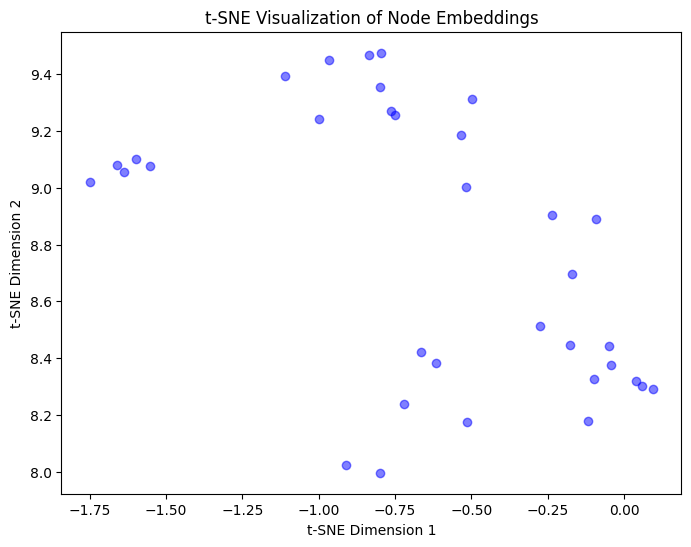

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load the embedding CSV file
embedding_df = pd.read_csv("karate_club_embeddings.csv")

# Extract the embedding vectors
embedding_vectors = embedding_df.iloc[:, 1:].values

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedding_tsne = tsne.fit_transform(embedding_vectors)

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c='b', alpha=0.5)
plt.title("t-SNE Visualization of Node Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
